## Remap from pressure/depth to isopycnals

It is useful to analyze the data on isopycnals for two reasons:
- Remove influence of internal waves
- Tracers are stirred primarily along isopycnals in the interior

Here we will do this remapping using linear interpolation, and start from the data that has already been QCed, overturns removed, and vertically binned.  

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal as sg
import spectrum 
from scipy import stats, fft
import xarray as xr
from cmocean import cm as cmo


In [3]:
import hvplot.xarray

In [4]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [5]:
ds_660_grid = xr.open_dataset('data/ctd_660_vert_binned_29_june_2021.nc')
# Calculate a time axis as YTD
days = ds_660_grid.time - np.datetime64('2019-01-01')
days_round_660 = (days / np.timedelta64(1, 'D')).round()
ds_660_grid['days'] = (days / np.timedelta64(1, 'D'))

In [6]:
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] 2019-04-30T12:15:30.70...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
    days          (ctd_pressure, dives) float64 119.5 119.5 119.5 ... nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-29 12:36:06] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

In [9]:
ds_660_grid.sigma0.sel(dives=100).hvplot()

:Curve   [ctd_pressure]   (sigma0)

#### Choosing density grid
We need to choose a density grid that results in very little loss of information, which means that having a variable $d\rho$ might be helpful. The steps can be finer in the mixed layer and deep ocean and less fine in the interior. 

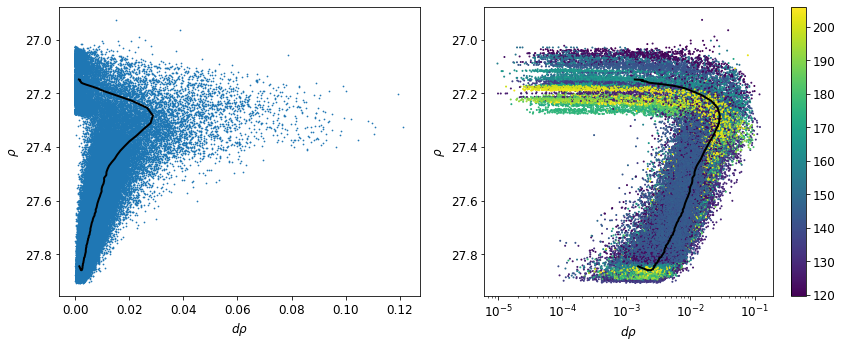

In [39]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(ds_660_grid.sigma0.diff('ctd_pressure'), ds_660_grid.sigma0[1:,:],
           s=0.5)
plt.plot(ds_660_grid.sigma0.diff('ctd_pressure').mean('dives'), 
         ds_660_grid.sigma0[1:,:].mean('dives'), color='k', linewidth=2)
plt.gca().invert_yaxis()
plt.xlabel(r'$d \rho$')
plt.ylabel(r'$\rho$')
#plt.xscale('log')

plt.subplot(122)
plt.scatter(ds_660_grid.sigma0.diff('ctd_pressure'), ds_660_grid.sigma0[1:,:],
           s=1, c=ds_660_grid.days[1:,:])
plt.plot(ds_660_grid.sigma0.diff('ctd_pressure').mean('dives'), 
         ds_660_grid.sigma0[1:,:].mean('dives'), color='k', linewidth=2)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel(r'$d \rho$')
plt.ylabel(r'$\rho$')

plt.tight_layout()

In [68]:
rho_grid = np.linspace(27.0, 27.9,901)

In [42]:
from scipy import interpolate

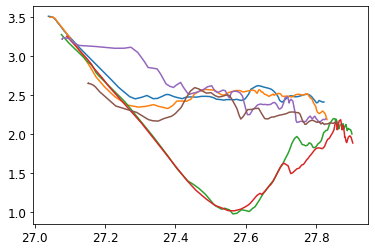

In [49]:
sel_dives = [20, 30, 100,105, 205, 300]
plt.plot(ds_660_grid.sigma0.sel(dives=sel_dives), ds_660_grid.CT.sel(dives=sel_dives))

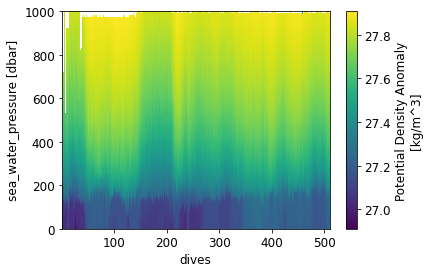

In [53]:
ds_660_grid.sigma0.plot()

#### Pressure to density grid
The interpolation requires us to invert functions like 
\begin{equation}
\rho = f(p)
\end{equation}
to 
\begin{equation}
p = g(\rho)
\end{equation}

and also
$$
T = f(p)
$$
to
$$
T = f(g(\rho))
$$

This can be done using interpolation, where we 
- take the variables as a function of pressure and the associated non-uniformly spaced density.
- Find the interpolant function that relates the variable to the non-uniformly spaced density.
- Use this interpolant function to estimate the values at a set of uniformly spaced density points. 

In [93]:
# Try on a single dive
dive_num = 100

rho = ds_660_grid.sigma0.sel(dives=dive_num)
rho_nonan = rho.where(~np.isnan(rho), drop=True)
pres_nonan = ds_660_grid.ctd_pressure.where(~np.isnan(rho), drop=True)
CT_nonan = ds_660_grid.CT.sel(dives=dive_num).where(~np.isnan(rho), drop=True)
SA_nonan = ds_660_grid.SA.sel(dives=dive_num).where(~np.isnan(rho), drop=True)

# Here we find the function p = f(\rho)
frho = interpolate.PchipInterpolator(rho_nonan, pres_nonan, extrapolate=False)#, bounds_error=False )
pres_tilde = frho(rho_grid)

# CT = f(\rho)
fCT = interpolate.PchipInterpolator(rho_nonan, CT_nonan, extrapolate=False)#, bounds_error=False )
CT_tilde = fCT(rho_grid)

# SA = f(\rho)
fSA = interpolate.PchipInterpolator(rho_nonan, SA_nonan, extrapolate=False)#, bounds_error=False )
SA_tilde = fSA(rho_grid)

(600.0, 900.0)

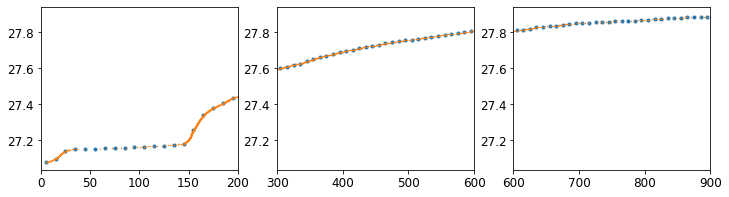

In [95]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(pres_nonan, rho_nonan, '.')
plt.plot(pres_tilde, rho_grid, '.', markersize=1)
plt.xlim([0,200])

plt.subplot(132)
plt.plot(pres_nonan, rho_nonan, '.')
plt.plot(pres_tilde, rho_grid, '.', markersize=1)
plt.xlim([300,600])

plt.subplot(133)
plt.plot(pres_nonan, rho_nonan, '.')
plt.plot(pres_tilde, rho_grid, '.', markersize=1)
plt.xlim([600,900])


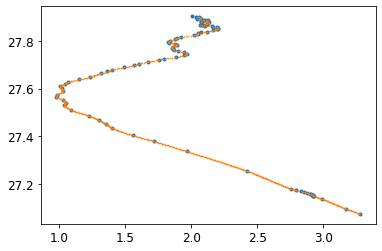

In [96]:
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)

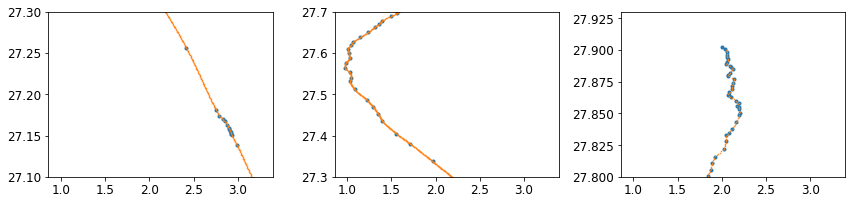

In [101]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.1,27.3])

plt.subplot(132)
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.3,27.7])

plt.subplot(133)
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.80,27.93])

plt.tight_layout()

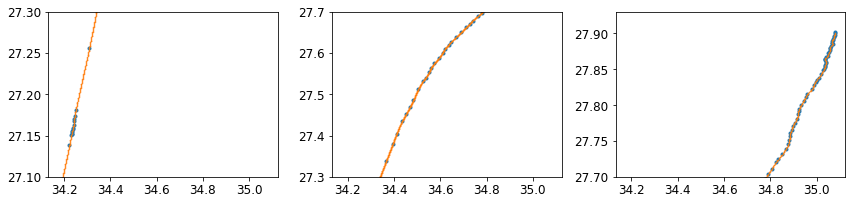

In [100]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(SA_nonan, rho_nonan, '.')
plt.plot(SA_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.1,27.3])

plt.subplot(132)
plt.plot(SA_nonan, rho_nonan, '.')
plt.plot(SA_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.3,27.7])

plt.subplot(133)
plt.plot(SA_nonan, rho_nonan, '.')
plt.plot(SA_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.7,27.93])

plt.tight_layout()

In [102]:
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] 2019-04-30T12:15:30.70...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
    days          (ctd_pressure, dives) float64 119.5 119.5 119.5 ... nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-29 12:36:06] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

In [110]:
pres_tilde.reshape((-1,1)).shape

(901, 1)

In [111]:
pres_tilde_xr = xr.DataArray( pres_tilde.reshape((-1,1)), 
            dims=['rho_grid', 'dives'],
            coords={'rho_grid':rho_grid, 'dives': [1.] })

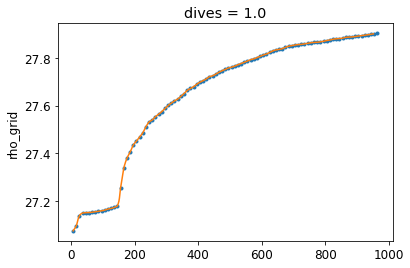

In [117]:
plt.plot(pres_nonan, rho_nonan, '.')
pres_tilde_xr.plot(y='rho_grid')

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/plot/plot.py:1039: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(x[0], x[-1])


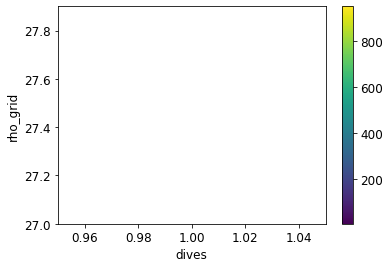

In [114]:
xr.concat([pres_tilde_xr, pres_tilde_xr], dim='dives').plot()

In [ ]:
# Apply to all dives
pres_tilde_xr

for dive_ind in [0,1]:#range(ds_660_grid):
    
    dive_num = ds_660_grid.dives.isel(dives=dive_ind)
    
    rho = ds_660_grid.sigma0.sel(dives=dive_num)
    rho_nonan = rho.where(~np.isnan(rho), drop=True)
    pres_nonan = ds_660_grid.ctd_pressure.where(~np.isnan(rho), drop=True)
    CT_nonan = ds_660_grid.CT.sel(dives=dive_num).where(~np.isnan(rho), drop=True)
    SA_nonan = ds_660_grid.SA.sel(dives=dive_num).where(~np.isnan(rho), drop=True)
    lat_nonan = ds_660_grid.latitude.sel(dives=dive_num).where(~np.isnan(rho), drop=True)    
    lon_nonan = ds_660_grid.longitude.sel(dives=dive_num).where(~np.isnan(rho), drop=True)
    days_nonan = ds_660_grid.days.sel(dives=dive_num).where(~np.isnan(rho), drop=True)
    
    # Here we find the function p = f(\rho)
    frho = interpolate.PchipInterpolator(rho_nonan, pres_nonan, extrapolate=False)#, bounds_error=False )
    pres_tilde = frho(rho_grid)
    pres_tilde_xr_temp = xr.DataArray( pres_tilde.reshape((-1,1)), 
                                dims=['rho_grid', 'dives'],
                                coords={'rho_grid':rho_grid, 'dives': [dive_num] })
    
    
    pres_tilde_xr = xr.merge([pres_tilde_xr, pres_tilde_xr_temp], dim='dives')

    # CT = f(\rho)
    fCT = interpolate.PchipInterpolator(rho_nonan, CT_nonan, extrapolate=False)#, bounds_error=False )
    CT_tilde = fCT(rho_grid)

    # SA = f(\rho)
    fSA = interpolate.PchipInterpolator(rho_nonan, SA_nonan, extrapolate=False)#, bounds_error=False )
    SA_tilde = fSA(rho_grid)
    
    # Latitude
    flat = interpolate.PchipInterpolator(rho_nonan, lat_nonan, extrapolate=False)#, bounds_error=False )
    lat_tilde = flat(rho_grid)
    
    # Longitude
    flon = interpolate.PchipInterpolator(rho_nonan, lon_nonan, extrapolate=False)#, bounds_error=False )
    lon_tilde = flon(lon_grid)    

    # Days (time)
    fdays = interpolate.PchipInterpolator(rho_nonan, days_nonan, extrapolate=False)#, bounds_error=False )
    days_tilde = fdays(rho_grid)    
    
    